In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import random
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Uncomment this for randomness
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# === Configuration ===
config = {
    "epochs": 1,
    "batch_size": 10,
    "initial_lr": 0.001,
    "gpu_memory_limit": 10,  # GB
    "target_size": (320, 480),  # 2:3 ratio (width, height)
    "input_shape": (480, 320, 3), # (height, width, channels) for Keras
    "data_path": "Dataset/preprocessed_images",
    "csv_path": "processed_data/cleaned_metadata_short.csv", #short is for testing flow only
    "train_set_csv": "training6/training6_train_set.csv",
    "val_set_csv": "training6/training6_validation_set.csv",
    "history_csv": "training6/training6_history.csv",
    "best_model": "training6/training6_best_model.keras",
    "label_encoder_path": "training6/training6_label_encoder.npy",
}


In [ ]:

# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Enable mixed precision
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        
        # Memory growth and optimization
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Model Architecture ===
def create_gpu_optimized_model(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype=tf.float16)
    
    # Initial feature extraction
    x = Conv2D(96, (7,7), strides=2, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Intermediate layers
    x = Conv2D(256, (5,5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2)(x)
    
    # Parallel paths
    branch1 = Conv2D(384, (3,3), activation='relu', padding='same')(x)
    branch2 = Conv2D(384, (3,3), dilation_rate=2, activation='relu', padding='same')(x)
    x = Concatenate()([branch1, branch2])
    
    # Final classification head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', name='features')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype=tf.float32)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape={config["input_shape"]}, gpu_mem=24):
    """Improved batch size calculator"""
    try:
        # Estimate memory usage per sample
        params = model.count_params()
        
        # Find last dense layer
        last_dense = next(layer for layer in reversed(model.layers) 
                     if isinstance(layer, Dense) and layer.name == 'features')
        
        # Memory estimation (conservative)
        per_sample = (params * 4 +  # 4 bytes per parameter
                     np.prod(input_shape) * last_dense.units * 4) / (1024**3)  # GB
        
        # Calculate max batch with 3GB buffer
        max_batch = int((gpu_mem - 3) / per_sample)
        
        return max(16, min(256, max_batch))
    
    except Exception as e:
        print(f"Error calculating batch size: {e}")
        return 32  # Fallback value

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    # Save label encoder classes
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    # Split data
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    # Save splits for later reference
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le

class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size={config['target_size']}, shuffle=False, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        
        self.aug = A.Compose([
            # A.RandomRotate90(),
            # A.HorizontalFlip(),
            # A.VerticalFlip(),
            # A.Transpose(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.HueSaturationValue(p=0.5),
            # A.CLAHE(p=0.5),
            A.Resize(width=self.target_size[0], height=self.target_size[1]), #Check
        ])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self._visualize_samples()    
            

    def _visualize_samples(self):
        """Visualize first 2 samples after augmentation"""
        
        for i in range(min(1, len(self.df))):
            try:
                row = self.df.iloc[i]
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                # print(f"Augmented shape: {row['image_id'], row['label']}")
                
                plt.figure(figsize=(12, 6))
                
                # original
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.title(f"Original\nShape: {img.shape}")
                
                # augmented
                plt.subplot(1, 2, 2)
                plt.imshow(augmented['image'])
                plt.title(f"Augmented\nShape: {augmented['image'].shape}")
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    @property
    def num_batches(self):
        return len(self)
    
    def _load_image(self, image_id, label, suffix='nipy_spectral'):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}_{suffix}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize using (width, height)
        img = cv2.resize(img, self.target_size)  
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                # No need to transpose - we'll match model to data shape
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

    def on_epoch_end(self):
        """Shuffle indices after each epoch"""
        if self.shuffle:
            np.random.shuffle(self.indices)

# === Training ===
def train():
    cleanup_gpu_memory()
    
    try:
        # Load data with fixed random state
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create model
        input_shape = config["input_shape"] #Check
        model = create_gpu_optimized_model(input_shape, num_classes)
        
        # Calculate batch size
        cleanup_gpu_memory()
        batch_size = calculate_max_batch_size(model)
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        # Create generators
        train_gen = RiceDataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=config["batch_size"],
            target_size=config["target_size"],
            shuffle=False,
            debug=True
        )
        
        val_gen = RiceDataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=config["batch_size"],
            target_size=config["target_size"],
            shuffle=False,
            debug=False
        )
        
        # Compile model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=10),
                tf.keras.callbacks.ModelCheckpoint(
                    config["best_model"],  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True
                )
            ]
        )
        
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [ ]:
def evaluate_saved_model(model_path, use_val_set=True):
    """Deterministic evaluation with debug checks"""
    try:
        # 1. Set determinism
        # tf.keras.utils.set_random_seed(42)
        # tf.config.experimental.enable_op_determinism()

        # 2. Load model and labels
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        custom_objects = {'AdamW': tf.keras.optimizers.AdamW}
        with tf.keras.utils.custom_object_scope(custom_objects):
            model = tf.keras.models.load_model(model_path, compile=False) 

        # 3. Compile with deterministic metrics
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        # 4. Load data with checks
        eval_df = pd.read_csv(config["train_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=config["batch_size"],
            target_size=config["target_size"],
            shuffle=False, 
            debug=True
        )

        # 5. Verify first batch consistency
        x_test, y_test = eval_gen[0]
        print(f"First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # 6. Evaluate
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\nEvaluation Results:", results)

        # 7. Predict with checks
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))
        
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true) == len(y_pred), "Label/prediction length mismatch!"
        
        # 8. Show prediction consistency
        print("\nPrediction samples:")
        for i in range(min(5, len(y_true))):
            print(f"True: {le.classes_[y_true[i]]} ({y_true[i]}) | Pred: {le.classes_[y_pred[i]]} ({y_pred[i]})")

        plot_confusion_matrix(y_true, y_pred, le.classes_)
        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot a detailed confusion matrix"""
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(include_values=True, ax=ax, cmap='viridis',
              xticks_rotation='vertical', values_format='d')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()    

Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak' 'blast' 'normal' 'tungro']
Classes:  5
Error calculating batch size: unsupported operand type(s) for *: 'set' and 'int'

=== Training Configuration ===
Batch size: 32
Input size: (320, 480)
Classes: 5
GPU Memory: 10GB

Model input shape: (None, 480, 320, 3)


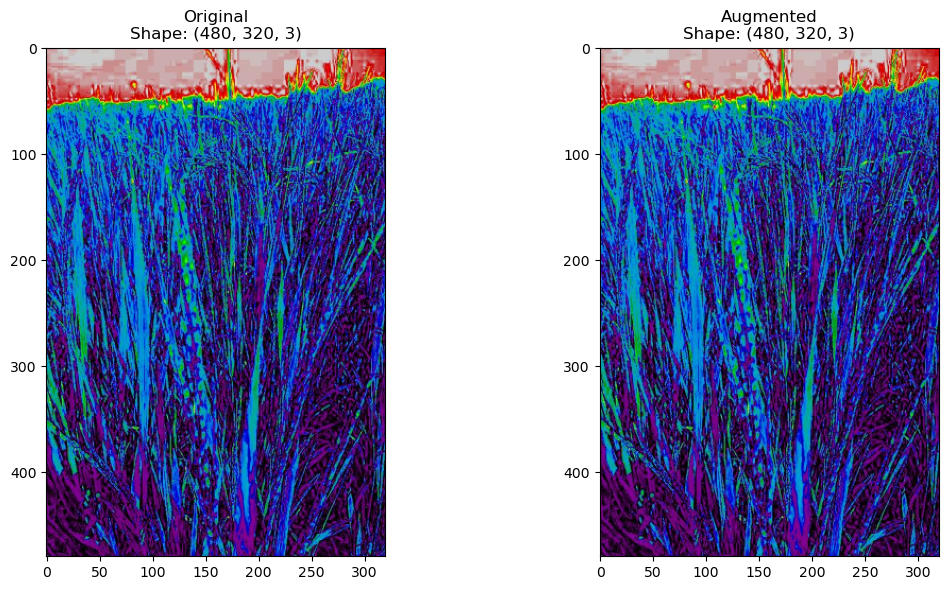

Generator output shape: (10, 480, 320, 3)
Model input shape: (None, 480, 320, 3)
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.1823 - loss: 4.6610 - val_accuracy: 0.2727 - val_loss: 1.4317
Evaluating on 44 samples


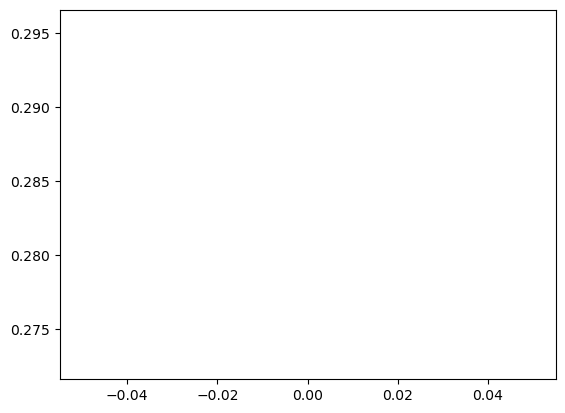

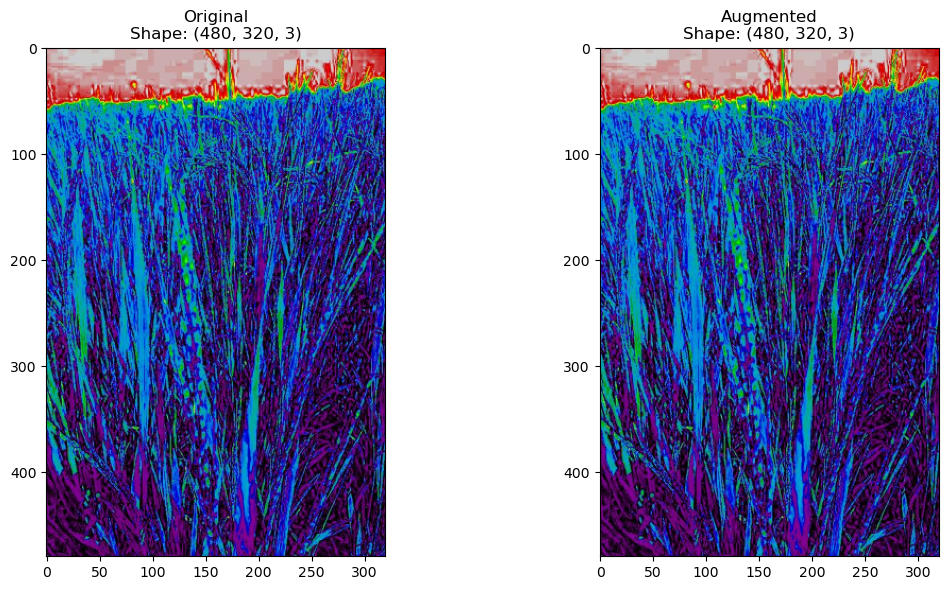

First batch - X shape: (10, 480, 320, 3), y shape: (10,)
Sample label: 3 -> normal
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 413ms/step - acc: 0.3471 - loss: 1.5167 - top3_acc: 0.7494

Evaluation Results: {'acc': 0.2954545319080353, 'loss': 1.5542705059051514, 'top3_acc': 0.7272727489471436}


2025-05-11 00:46:47.309454: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



Prediction samples:
True: normal (3) | Pred: bacterial_leaf_streak (1)
True: normal (3) | Pred: tungro (4)
True: bacterial_leaf_blight (0) | Pred: bacterial_leaf_streak (1)
True: bacterial_leaf_streak (1) | Pred: bacterial_leaf_streak (1)
True: bacterial_leaf_streak (1) | Pred: bacterial_leaf_streak (1)


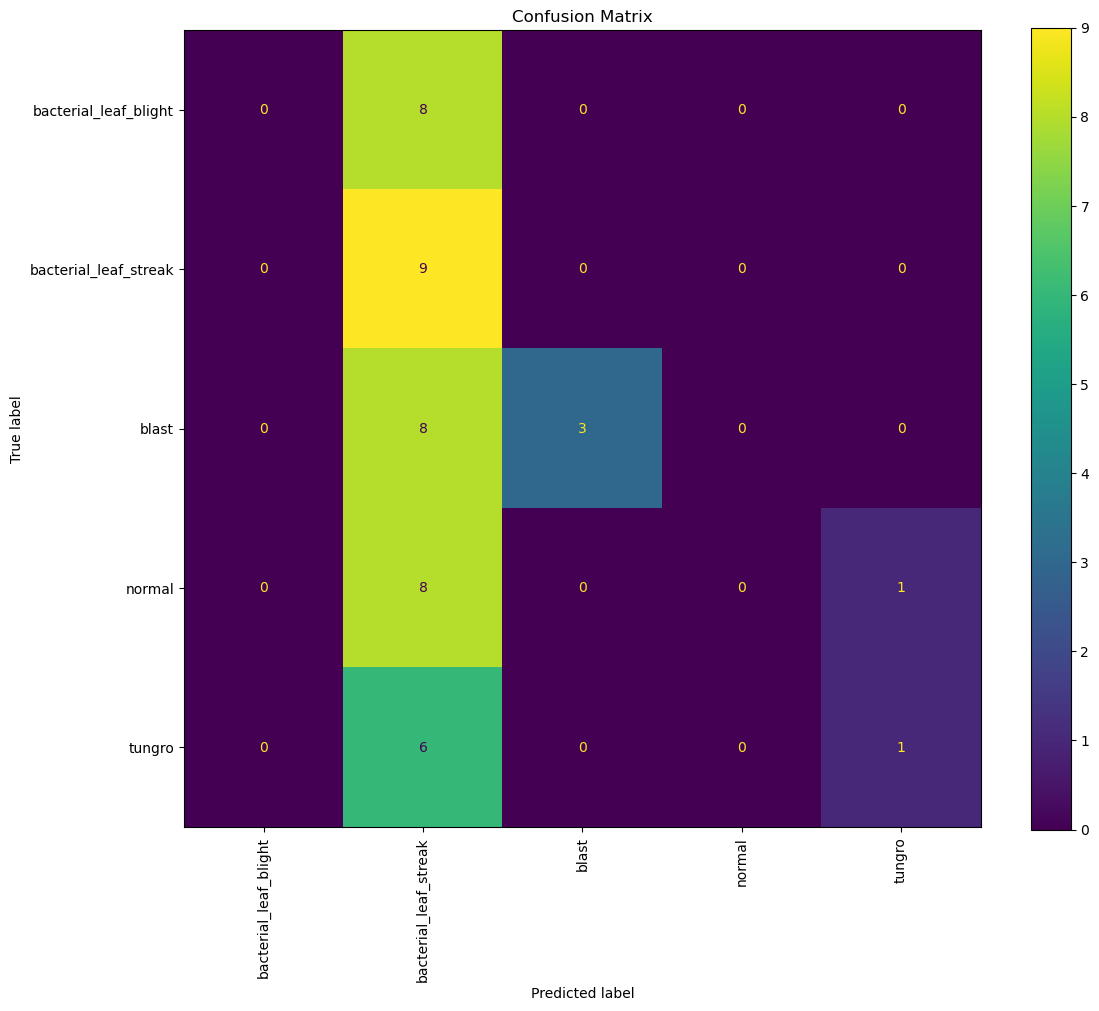

In [385]:
# === Execution Options ===
if __name__ == "__main__":
    # Option 1: Train and evaluate
    model, model_history = train()
    # model.save(config["best_model"])
    evaluate_saved_model(config["best_model"], use_val_set=True)